In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from kneed import KneeLocator
from scipy.interpolate import interp1d
sns.set()

/home/hack_summer/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import sys
# import mss
sys.path.append('../')
from mss import visreader as mvis
from mss import mssmain as msm
from mss import align
import pandas as pd
import numpy as np
from tqdm import tqdm

/home/hack_summer/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.

/home/hack_summer/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.



In [ ]:
mz_list = [100,100.5,100.6,100.7,100.8]
mz_locator (100,50 ppm(relative error),mz_list)
100*(1-50*10e-6)

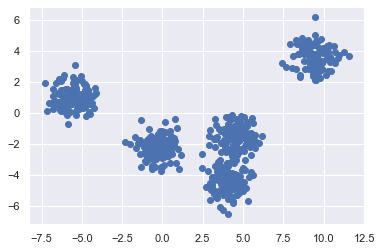

In [62]:
x1,y = make_blobs(n_samples=600, centers=5, cluster_std=0.7, random_state=123)
plt.scatter(x1[:,0], x1[:,1])

In [102]:
test = pd.read_csv('D:/UW/directproject/example_data/example_peaklist/test_vali.csv')
test = test.iloc[:,-3:]

In [124]:
# in case minPts = 5
def eps_assess(data, min_pts):
    neigh = NearestNeighbors(n_neighbors=min_pts)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    x = np.arange(1, len(distances)+1)
    y = distances
    plt.plot(x, y)
    f = interp1d(x,y)
    kn = KneeLocator(x, y, curve='convex', direction='increasing')
    plt.scatter(kn.knee, f(kn.knee),color='red', marker='+',s=50)
    print('eps selected', f(kn.knee))
    return distances

eps selected 14923957.566044604


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.60649940e+07, 5.93102560e+07, 1.54609692e+08])

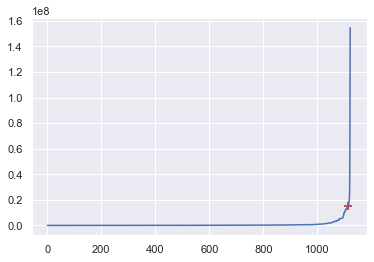

In [126]:
eps_assess(test,200)

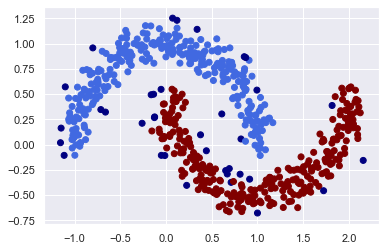

In [36]:
m = DBSCAN(eps=0.1,min_samples = 5)
m.fit(x2)
clusters = m.labels_
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(x2[:,0], x2[:,1], c=vectorizer(clusters))

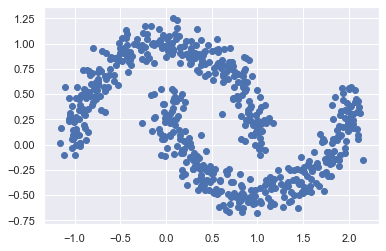

In [16]:
x2,y = make_moons(n_samples=600, noise=0.1)
plt.scatter(x2[:,0], x2[:,1])

In [55]:
import time

start = time.time()

a = 1
b = 1
c = a+b
%time print(c)

print(f'Time: {time.time() - start}')

2
Wall time: 968 µs
Time: 0.0009684562683105469


# Instrumentation

In [5]:
import instrument
from time import sleep

In [72]:
@instrument.function()
def func():
    j = []
    for i in np.arange(0,10):
        i += 1
        j.append(i)
    print(j)
    return ('func')
func()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
__main__.func: 1 items in 0.00 seconds


'func'

In [91]:
with instrument.block(name="slowcode"):
    j = []
    for i in np.arange(0,1000000):
        j.append(i)

slowcode: 1 items in 0.18 seconds


In [92]:
def math_is_hard(N):
    x = 0
    while x < N:
        sleep(.1)
        yield x * x
        x += 1

_ = instrument.each(math_is_hard(5))
# squares = list(_)

In [9]:
import timeit
import time
def long_function():
    print('function start')
    time.sleep(5)
    print('function end')
print(timeit.Timer(long_function).timeit(number=2))

function start
function end
function start
function end
10.01207389999999


In [ ]:
import sys
# import mss
sys.path.append('../')
from mss import visreader as mvis
from mss import mssmain as msm
from mss import align
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
path = '../example_data/ex_1.mzML'
scans = msm.get_scans(path, ms_all=False, ms_lv=1)
#noise removal
msm.noise_removal(scans, 2000)

In [6]:
def ms_chromatogram_list(mzml_scans, input_mz, error):
    '''
    Generate a peak list for specific input_mz over
    whole rt period from the mzml file
    ***Most useful function!
    '''

    # Create empty list to store the data
    retention_time = []
    intensity = []
    for scan in mzml_scans:
        retention_time.append(scan.scan_time[0])
        _, target_index = msm.mz_locator(scan.mz, input_mz, error)
        if len(target_index) == 0:
            intensity.append(0)
        else:
            # intensity.append(scan.i[target_index])
            # CR -> if all_than_close=True
            # Change from sum to max
            intensity.append(max(scan.i[target_index]))

    return retention_time, intensity

In [161]:
with instrument.block(name="mzlocator"):
    mzml_scans = scans
    input_mz = 299.1765
    error = 500
    retention_time = []
    intensity = []
    for scan in mzml_scans: #iteration efficiency is low
        retention_time.append(scan.scan_time[0])
        _, target_index = msm.mz_locator(scan.mz, input_mz, error)
        if len(target_index) == 0:
            intensity.append(0)
        else:
            # intensity.append(scan.i[target_index])
            # CR -> if all_than_close=True
            # Change from sum to max
            intensity.append(max(scan.i[target_index]))

mzlocator: 1 items in 0.27 seconds


In [165]:
with instrument.block(name="mzlocator"):
    for scan in scans:
        input_list = scan.mz
        mz = 119.08
        error = 500
        target_mz = []
        target_index = []

        # ppm conversion
        error = error * 1e-6

        lower_mz = mz - error * mz
        higher_mz = mz + error * mz

        for i, mzs in enumerate(input_list):
            if mzs < lower_mz:
                continue
            elif mzs >= lower_mz:
                if mzs <= higher_mz:
                    target_mz.append(mzs)
                    target_index.append(i)
        t_mz = target_mz
        t_i = target_index
        

mzlocator: 1 items in 0.38 seconds


In [16]:
mzg = range(100)

In [17]:
def test():
    final_mz=[]
    for m in mzg:
        lm = m - 1
        hm = m + 1
        if len([i for i in mzg if i<=hm and i>=lm]) >= 2:
            final_mz.append(m)
    return
%timeit test()

410 µs ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
path = '../example_data/ex_1.mzML'
scans = msm.get_scans(path, ms_all=False, ms_lv=1)
#noise removal
msm.noise_removal(scans, 2000)

In [100]:
def mz_locator(input_list, mz, error, all_than_close=True):
    '''
    Find specific mzs from given mz and error range out from a given mz array
    input list: mz list
    mz: input_mz that want to be found
    error: error range is now changed to ppm level
    all_than_close: False only select closest one, True will append all
    '''
    # np.asarray(input_list)
    target_mz = []
    target_index = []

    # ppm conversion
    error = error * 1e-6

    lower_mz = mz - error * mz
    higher_mz = mz + error * mz

    #cython/numpy array
    # 1. keep as python, but change to tuple append rather than two seperate list append
    # 2. cython --> faster python loop --> seperate function?
    # Check list comprehension
    # boolean index 
    # https://towardsdatascience.com/speeding-up-python-code-fast-filtering-and-slow-loops-8e11a09a9c2f
    # index = (mzs <= higher_mz) & (mzs >= lower_mz)
    for i, mzs in enumerate(input_list):
        if mzs >= lower_mz and mzs <= higher_mz:
            target_mz.append(mzs)
            target_index.append(i)

    if all_than_close is False:
        if len(target_mz) != 0:
            target_error = [abs(i - mz) for i in target_mz]
            minpos = target_error.index(min(target_error))
            t_mz = target_mz[minpos]
            t_i = target_index[minpos]
        else:
            t_mz = 0
            t_i = 'NA'
    if all_than_close is True:
        t_mz = target_mz
        t_i = target_index

    return t_mz, t_i

In [42]:
def mz_locator(input_list, mz, error, all_than_close=True):
    # ppm conversion
    error = error * 1e-6

    lower_mz = mz - error * mz
    higher_mz = mz + error * mz

    target_list = [(i,j) for i, j in enumerate(input_list) if j >= lower_mz and j <= higher_mz]

    if all_than_close is False:
        if len(target_mz) != 0:
            target_error = [abs(i - mz) for i in target_mz]
            minpos = target_error.index(min(target_error))
            t_mz = target_mz[minpos]
            t_i = target_index[minpos]
        else:
            t_mz = 0
            t_i = 'NA'
    if all_than_close is True:
        t_mz = [i[1] for i in target_list]
        t_i = [i[0] for i in target_list]

    return t_mz, t_i

In [44]:
%timeit msm.mz_locator(scans[1].mz,199.08,50)

7.62 µs ± 828 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [101]:
%timeit mz_locator(scans[1].mz,119.08,50)

9.08 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [49]:
input_list = scans[1].mz
array = np.asarray(input_list)

In [55]:
index = (array>=107) & (array<=120)

In [63]:
np.where(index)

(array([1, 2]),)

In [103]:
input_list = scans[1].mz
array = np.asarray(input_list)

def boolean_index(array,mz,error,all_than_close=True):
    #array = np.asarray(input_list)
    error = error * 1e-6

    lower_mz = mz - error * mz
    higher_mz = mz + error * mz
    

    index = (array >= lower_mz) & (array <= higher_mz)

    return array[index],np.where(index)[0]

print('Boolean index:\t', end='')
%timeit boolean_index(array,119.08,50)

Boolean index:	4.31 µs ± 418 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [90]:
boolean_index(input_list,119.08,50)

(array([119.0813377]), array([2]))

In [98]:
def ms_chromatogram_list(mzml_scans, input_mz, error):
    '''
    Generate a peak list for specific input_mz over
    whole rt period from the mzml file
    ***Most useful function!
    '''

    # Create empty list to store the data
    retention_time = []
    intensity = []
    for scan in mzml_scans:
        retention_time.append(scan.scan_time[0])
        _, target_index = mz_locator(scan.mz, input_mz, error)
        if len(target_index) == 0:
            intensity.append(0)
        else:
            intensity.append(max(scan.i[target_index]))

    return retention_time, intensity
%timeit ms_chromatogram_list(scans,299.1765,5000)

198 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


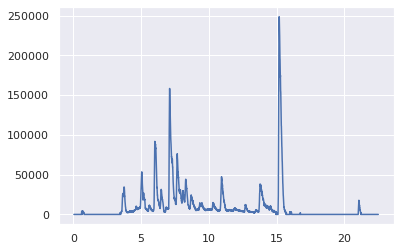

In [95]:
i,j = ms_chromatogram_list(scans,299.1765,5000)
plt.plot(i,j)